Processing α = 0.5
Processing α = 1.0
Processing α = 2.0
Processing α = 3.0
Processing α = 4.0
Processing α = 5.0
Processing α = 6.0
Processing α = 7.0


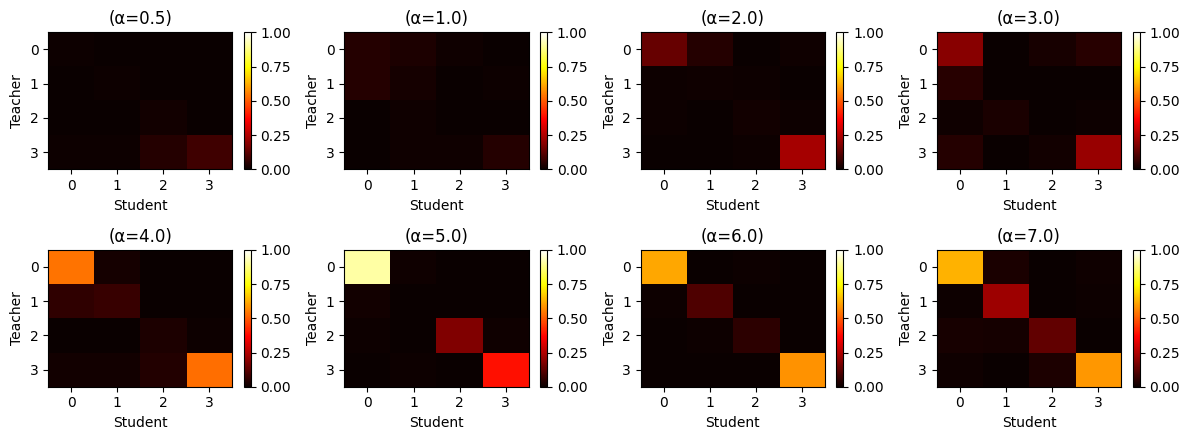

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
tf.config.set_visible_devices(tf.config.list_physical_devices('GPU')[1], 'GPU')
import hmc2
from scipy.sparse import csr_array
from scipy.sparse.csgraph import min_weight_full_bipartite_matching as match

d = 200
k = 4
alpha_values = [ 0.5, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0]
Delta = 0.1
v = tf.constant([-3.0, -1.0, 1.0, 3.0], dtype=tf.float32)
v -= tf.reduce_mean(v)
v /= tf.norm(v)
prior = 'gauss'

#sig = lambda x: (x**2 - 1)/np.sqrt(2.0) + (x**3 - 3*x)/6
sig = lambda x: x + (x**2 - 1)/np.sqrt(2.0) + (x**3 - 3*x)/6
#sig = lambda x: tf.sign(x)
#sig = tf.nn.tanh

mean_diagonal_overlaps_info = []

def fix_teacher_order(S, v):
    """
    Sort the rows of the alignment matrix S according to increasing v (teacher readout weights).
    """
    idx = np.argsort(v)
    return S[idx, :]


params = {
    'step_size': 0.01,
    'num_leapfrog_steps': 10,
    'num_adaptation_steps': 2000,
    'num_post_adapt_steps': 4
}

# subplot

n_1 = len(alpha_values)
assert n_1 <= 8, "You can only plot up to 8 alpha values in a 2x4 grid."

fig, axes = plt.subplots(2, 4, figsize=(12, 4.5), tight_layout=True)  
axes = axes.reshape(2, 4)  

for i, alpha in enumerate(alpha_values):
    print(f"Processing α = {alpha}")
    
    # Generate data
    W0, X, Y, v = hmc2.data_generate(d, k, alpha, Delta, sig, v)
    W_ = tf.random.normal((k, d), dtype=tf.float32)
    
    # Posterior sampling
    Ws_info = hmc2.hmc(params, W0, X, Y, v, k, alpha, Delta, sig, show_acceptance_rate=False, show_adaptation_steps=True)
    # Final samples
    Wi = Ws_info[-1]

    # Compute alignment matrices
    Si = fix_teacher_order((W0 @ tf.transpose(Wi) / d).numpy(), v.numpy())
    Si_sq = Si**2

    row, col_base = divmod(i, 2)
    col = 2 * col_base
    # Plot informative
    ax1 = axes.flatten()[i]
    im1 = ax1.imshow(Si_sq, cmap='hot', aspect='auto', vmin=0, vmax=1)
    ax1.set_title(f'(α={alpha})')
    ax1.set_xlabel('Student')
    ax1.set_ylabel('Teacher')
    plt.colorbar(im1, ax=ax1)
plt.subplots_adjust(top=0.92)
plt.savefig("Overlap_matrix.png", dpi=300, bbox_inches='tight')
plt.show()

Training for alpha = 0.5
Training for alpha = 1.0
Training for alpha = 2.0
Training for alpha = 3.0
Training for alpha = 4.0
Training for alpha = 5.0
Training for alpha = 6.0
Training for alpha = 7.0


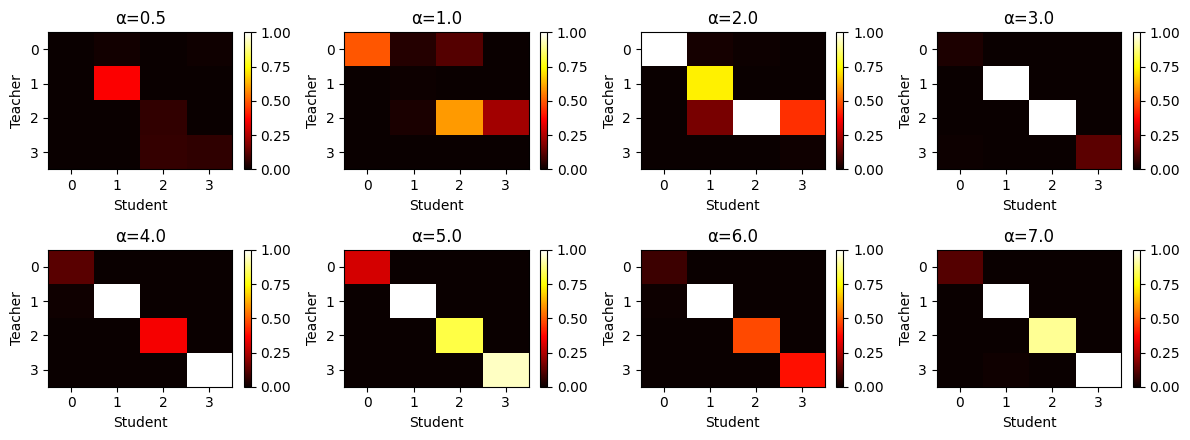

In [22]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
tf.config.set_visible_devices(tf.config.list_physical_devices('GPU')[1], 'GPU')

import hmc2

from scipy.sparse import csr_array
from scipy.sparse.csgraph import min_weight_full_bipartite_matching as match

def per(M):
    size, _ = M.shape
    per_index = match(csr_array(M), maximize=True)
    per_matrix = np.zeros((size, size), dtype=int)
    per_matrix[per_index[0], per_index[1]] = 1
    M_ = per_matrix.T @ M
    return M_

def fix_teacher_order(S, v):
    """
    Fix row order based on sorted teacher readout weights v.
    """
    idx = np.argsort(v)
    return S[idx, :]



# tecaher activation
#sig_t = lambda x: tf.sign(x)
sig_t = lambda x: x + (x**2 - 1)/np.sqrt(2.0) + (x**3 - 3*x)/6

# ------------------------------
# Data generation (teacher)
# ------------------------------
def data_generate(d, k, alpha, Delta, sig_t, v):
    c_k, c_d = 1/np.sqrt(k), 1/np.sqrt(d)
    n = int((alpha*d**2)/np.sqrt(d))
    W0 = tf.random.normal((k, d), dtype=tf.float32)
    X = tf.random.normal((d, n), dtype=tf.float32)
    Z = tf.random.normal((n,), dtype=tf.float32)
    M = sig_t(W0 @ X * c_d)
    Y = tf.tensordot(v, M, axes=1) * c_k + tf.sqrt(Delta) * Z
    return W0, X, Y, v

# ------------------------------
# Student training
# ------------------------------
def train_student(X, Y, k, d, v, Delta, sig, lr=0.05, steps=1000, track_alignments=False, W0=None):
    c_k, c_d = 1/np.sqrt(k), 1/np.sqrt(d)
    W = tf.Variable(tf.random.normal((k, d), dtype=tf.float32))
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    snapshots = []

    for step in range(steps):
        with tf.GradientTape() as tape:
            M = sig(W @ X * c_d)
            Y_hat = tf.tensordot(v, M, axes=1) * c_k
            loss = tf.reduce_mean((Y_hat - Y)**2) / (2 * Delta)
        grads = tape.gradient(loss, [W])
        optimizer.apply_gradients(zip(grads, [W]))

        if track_alignments and step % 100 == 0:
            S = (W0 @ tf.transpose(W) / d).numpy()
            snapshots.append(S)

    if track_alignments:
        return W.numpy(), snapshots
    else:
        return W.numpy()

# ------------------------------
# Experiment setup
# ------------------------------
d, k = 150, 4
#alpha_values = [0.2,1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.5]
alpha_values = [ 0.5, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0]
Delta = 0.5
v = tf.constant([-3, -1, 1, 3], dtype=tf.float32)
v = v - tf.reduce_mean(v)
v /= tf.norm(v)

sig = lambda x: x + (x**2 - 1)/np.sqrt(2.0) + (x**3 - 3*x)/6
alignments = []
alpha_6_snapshots = []
mean_diagonal_overlaps_gd = []


for alpha in alpha_values:
    print(f"Training for alpha = {alpha}")
    W0, X, Y, _ = data_generate(d, k, alpha, Delta, sig, v)

    if alpha == 6:
        W_student, alpha_6_snapshots = train_student(
            X, Y, k, d, v, Delta, sig, track_alignments=True, W0=W0)
    else:
        W_student = train_student(X, Y, k, d, v, Delta, sig)

    S = W0 @ tf.transpose(W_student) / d
    alignments.append(S.numpy()**2)
    
    S_gd = S**2

fig, axes = plt.subplots(2, 4, figsize=(12, 4.5), tight_layout=True)
axes = axes.flatten()

for i, (S, alpha) in enumerate(zip(alignments, alpha_values)):
    ax = axes[i]
    
    # Fix teacher order based on v = [-3, -1, 1, 3]
    S_fixed = fix_teacher_order(S, v.numpy())
    
    # Apply Hungarian matching (optimal student permutation)
    S_aligned_1 = per(S_fixed)
    S_aligned = S_aligned_1**2
    mean_diag_gd = np.mean(np.diag(S_aligned))
    mean_diagonal_overlaps_gd.append(mean_diag_gd)

    # Plot
    im = ax.imshow(S_aligned, cmap='hot', aspect='auto', vmin=0, vmax=1)
    ax.set_xlabel('Student')
    ax.set_ylabel('Teacher')
    ax.set_title(f"α={alpha}")
    plt.colorbar(im, ax=ax)

plt.subplots_adjust(top=0.92)
plt.savefig("Overlap_sgd.png", dpi=300, bbox_inches='tight')

plt.show()

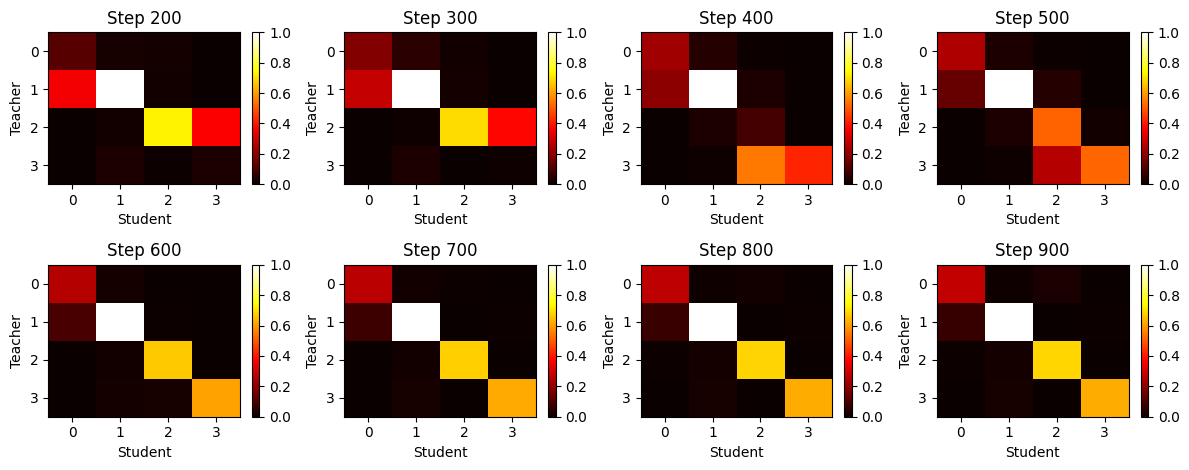

In [23]:
# Plot evolution of alignment matrix for alpha = 6 (from step 200 to 1000)
start_index = 2  # step 200 is the 3rd snapshot (0-indexed: 0,100,200 → index2)
end_index = 10   # step 900 is the 10th snapshot (0-indexed: 900 is index9)

selected_snapshots = alpha_6_snapshots[start_index:end_index]  # 8 snapshots (200-900)
num_snapshots = len(selected_snapshots)

fig, axes = plt.subplots(2, 4, figsize=(12, 4.8), tight_layout=True)
axes = axes.flatten()

for i, S in enumerate(selected_snapshots):
    ax = axes[i]
    aligned = per(S)
    step_number = (start_index + i) * 100  # Calculate actual step (200, 300, ..., 900)
    im = ax.imshow(aligned**2, cmap='hot', aspect='auto', vmin=0, vmax=1)
    ax.set_title(f"Step {step_number}")
    ax.set_xlabel("Student")
    ax.set_ylabel("Teacher")
    plt.colorbar(im, ax=ax)

# Hide any unused subplots (we have exactly 8 snapshots so this won't execute)
for j in range(num_snapshots, 8):
    fig.delaxes(axes[j])

#plt.suptitle("Evolution of Alignment Matrix for α = 6 (Steps 200–900)", fontsize=16)
plt.savefig("alignment_evolution_alpha6_200_900_1.png", dpi=300, bbox_inches='tight')
plt.show()

In [6]:
import tensorflow as tf
tf.config.set_visible_devices(tf.config.list_physical_devices('GPU')[1], 'GPU')
import math
import numpy as np
from numpy.polynomial.hermite_e import hermegauss
from scipy.integrate import quad
from scipy.interpolate import UnivariateSpline
import matplotlib.pyplot as plt
import hmc2 

I0000 00:00:1755042422.386426 1726896 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14079 MB memory:  -> device: 1, name: NVIDIA RTX A4000, pci bus id: 0000:65:00.0, compute capability: 8.6


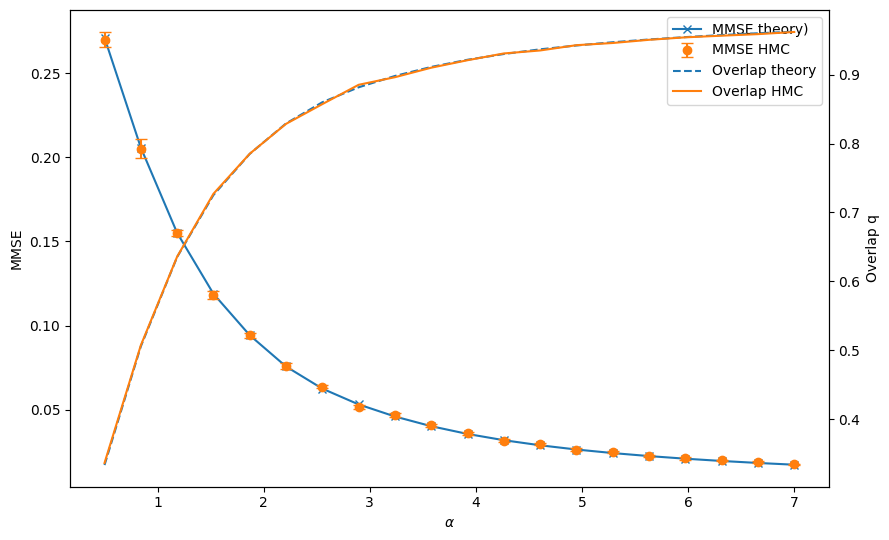

In [4]:
np.random.seed(123)
tf.random.set_seed(123)

N_GH = 150
xs, ws = hermegauss(N_GH)

def Ez(f):
    """E[f(Z)] for Z~N(0,1) using Gauss–Hermite."""
    return float(np.sum(ws * f(xs)) / np.sqrt(2*np.pi))

def P_y_given_u(y, u, sig, q, Delta):
    inner = lambda v: np.exp(-(y - sig(np.sqrt(q)*u + np.sqrt(1-q)*v))**2 / (2*Delta))
    return Ez(inner) / np.sqrt(2*np.pi*Delta)

def H_Y_u(u, sig, q, Delta):
    pad = 8.0
    ymin = -1 - pad*np.sqrt(Delta)
    ymax =  1 + pad*np.sqrt(Delta)
    p  = lambda y: P_y_given_u(y, u, sig, q, Delta)
    integrand = lambda y: -p(y) * np.log(p(y) + 1e-16)
    val, _ = quad(integrand, ymin, ymax, epsabs=1e-7, epsrel=1e-6, limit=200)
    return val

H_Y_u_vec = np.vectorize(H_Y_u, otypes=[float])

def H_Y_U(sig, q, Delta):
    return Ez(lambda u: H_Y_u_vec(u, sig, q, Delta))

def make_dH_dq(sig, Delta, smoothing_grid=61, smooth=True):
    if not smooth:
        def diff_centered(f, x, eps=1e-3):
            x = float(np.clip(x, 1e-6, 1-1e-6))
            if x < 1e-6 + eps:
                return (f(x + eps) - f(x)) / eps
            if x > 1 - 1e-6 - eps:
                return (f(x) - f(x - eps)) / eps
            return (f(x + eps) - f(x - eps)) / (2*eps)
        return lambda q: diff_centered(lambda qq: H_Y_U(sig, qq, Delta), q, 1e-3)

    qs = np.linspace(1e-4, 1-1e-4, smoothing_grid)
    HY = np.array([H_Y_U(sig, q, Delta) for q in qs], dtype=float)
    spline = UnivariateSpline(qs, HY, s=1e-6, k=3)
    dspline = spline.derivative()
    return lambda q: float(dspline(float(np.clip(q, 1e-6, 1-1e-6))))

def He_rec(x, n):
    if n == 0:
        return np.ones_like(x)
    if n == 1:
        return x
    a, b = np.ones_like(x), x
    for k in range(2, n+1):
        a, b = b, x*b - (k-1)*a
    return b

def hermite_coeffs(sig_np, nmax):
    coeffs = np.empty(nmax+1, dtype=float)
    for n in range(nmax+1):
        coeffs[n] = Ez(lambda z: sig_np(z) * He_rec(z, n))
    return coeffs

def make_h_poly(sig_np, nmax=80):
    coeffs = hermite_coeffs(sig_np, nmax)
    facs = np.array([math.factorial(i) for i in range(nmax+1)], dtype=float)
    terms = (coeffs*coeffs) / facs  
    def hq(q):
        q = float(np.clip(q, 0.0, 1.0))
        powers = np.array([q**i for i in range(len(terms))], dtype=float)
        return float(np.dot(terms, powers))
    return hq

def mmse_theory_curve(alpha_values, Delta, sig_np, h_poly,
                      q_init=1e-4, eta=0.35, max_iter=600, tol=5e-5,
                      use_spline_derivative=True):
    dH = make_dH_dq(sig_np, Delta, smooth=use_spline_derivative)
    mmse_list, q_list = [], []
    q_prev = float(q_init)
    for a in alpha_values:
        q = float(q_prev)
        for _ in range(max_iter):
            r = -2.0 * float(a) * dH(q)
            q_new = r / (r + 1.0)
            q = (1 - eta) * q + eta * q_new
            q = float(np.clip(q, 1e-6, 1 - 1e-6))
            if abs(q - q_new) < tol:
                break
        mmse_list.append(h_poly(1.0) - h_poly(q))
        q_list.append(q)
        q_prev = q
    return np.array(mmse_list, dtype=float), np.array(q_list, dtype=float)

def norms_and_overlap(w_star, w):
    n = w.size
    q_star = float(np.dot(w_star, w_star) / n)
    q = float(np.dot(w, w) / n)
    m = float(np.dot(w_star, w) / n)
    denom = math.sqrt(max(q_star, 1e-16) * max(q, 1e-16))
    rho = m / denom
    return q_star, q, rho, m

def empirical_q_and_mmse_for_alpha(alpha, Delta, sig_tf, h_poly, v_vec,
                                   d=1000, k=1, runs=8, params=None,
                                   burn_in_fraction=0.5, thin=10):
    if params is None:
        params = dict(step_size=0.01,
                      num_leapfrog_steps=24,
                      num_adaptation_steps=2000,
                      num_post_adapt_steps=200)

    q_runs, mmse_runs = [], []

    for _ in range(runs):
        w_star, X, Y, v_hmc = hmc2.data_generate(d, k, alpha, Delta, sig_tf, v_vec)
        Ws_info = hmc2.hmc(params, w_star, X, Y, v_hmc, k, alpha, Delta, sig_tf,
                           show_acceptance_rate=False, show_adaptation_steps=False)

        b = int(len(Ws_info) * burn_in_fraction)
        samples = Ws_info[b::thin] if thin > 1 else Ws_info[b:]

        w_star_np = w_star.numpy().ravel()
        rhos = []
        for Wi in samples:
            wi = Wi.numpy().ravel()
            _, _, rho, m = norms_and_overlap(w_star_np, wi)
            rho_aligned = abs(rho) if m < 0 else rho  
            rhos.append(float(np.clip(rho_aligned, 0.0, 1.0)))

        q_post = float(np.mean(rhos)) if rhos else 0.0
        q_post = float(np.clip(q_post, 1e-6, 1 - 1e-6))
        q_runs.append(q_post)
        mmse_runs.append(h_poly(1.0) - h_poly(q_post))

    return np.array(q_runs, dtype=float), np.array(mmse_runs, dtype=float)

def empirical_qmmse_stats(alpha_values, Delta, sig_tf, h_poly, v_vec,
                          d=1000, k=1, runs=8, params=None,
                          burn_in_fraction=0.5, thin=10):
    """Means and SEMs for q and MMSE across runs, per alpha."""
    q_means, q_sems, mmse_means, mmse_sems = [], [], [], []
    for a in alpha_values:
        q_vals, mmse_vals = empirical_q_and_mmse_for_alpha(
            a, Delta, sig_tf, h_poly, v_vec,
            d=d, k=k, runs=runs, params=params,
            burn_in_fraction=burn_in_fraction, thin=thin
        )
        q_means.append(q_vals.mean())
        q_sems.append(q_vals.std(ddof=1)/np.sqrt(len(q_vals)) if len(q_vals) > 1 else 0.0)
        mmse_means.append(mmse_vals.mean())
        mmse_sems.append(mmse_vals.std(ddof=1)/np.sqrt(len(mmse_vals)) if len(mmse_vals) > 1 else 0.0)
    return (np.array(q_means), np.array(q_sems),
            np.array(mmse_means), np.array(mmse_sems))

def check_design_scaling(X, w_star):
    s = tf.linalg.matvec(X, w_star).numpy()
    var_emp = float(np.var(s))
    q_star = float(tf.tensordot(w_star, w_star, axes=1).numpy() / w_star.shape[0])
    ratio = var_emp / q_star if q_star > 0 else float('nan')
    print(f"[scaling] Var(X w*) ≈ {var_emp:.4f}; q* ≈ {q_star:.4f}; ratio={ratio:.2f} "
          f"(expect ~1 if X ~ N(0, I/d))")

if __name__ == "__main__":
    sig_np = np.tanh
    sig_tf = tf.nn.tanh
    Delta = 0.1

    h_poly = make_h_poly(sig_np, nmax=80)
    alpha_values = np.linspace(0.5, 7.0, 20)

    mmse_theory, q_theory = mmse_theory_curve(
        alpha_values, Delta, sig_np, h_poly,
        q_init=1e-4, eta=0.35, max_iter=600, tol=5e-5,
        use_spline_derivative=True
    )

    hmc_params = dict(
        step_size=0.01,
        num_leapfrog_steps=24,
        num_adaptation_steps=2000,
        num_post_adapt_steps=200,
    )

    d = 1000
    k = 1
    runs = 8
    v_vec = tf.ones((k,), dtype=tf.float32)

    q_emp_mean, q_emp_sem, mmse_emp_mean, mmse_emp_sem = empirical_qmmse_stats(
        alpha_values, Delta, sig_tf, h_poly, v_vec,
        d=d, k=k, runs=runs, params=hmc_params,
        burn_in_fraction=0.5, thin=10
    )

    fig, ax1 = plt.subplots(figsize=(9, 5.5))

    ax1.plot(alpha_values, mmse_theory, 'x-', label='MMSE theory)')
    ax1.errorbar(alpha_values, mmse_emp_mean, yerr=1.96*mmse_emp_sem,
                 fmt='o', linestyle='None', capsize=4,  
                 label='MMSE HMC')
    ax1.set_xlabel(r'$\alpha$')
    ax1.set_ylabel('MMSE')

    ax2 = ax1.twinx()
    ax2.plot(alpha_values, q_theory, '--', label='Overlap theory')
    ax2.errorbar(alpha_values, q_emp_mean, linestyle='-', label='Overlap HMC')
    ax2.set_ylabel('Overlap q')

    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    ax1.legend(h1 + h2, l1 + l2, loc='best')
    #leg = ax1.legend( h1 + h2, l1 + l2, loc='center left',  bbox_to_anchor=(1.02, 0.5), borderaxespad=0.0,frameon=True )
    #fig.subplots_adjust(right=0.78)   
    plt.tight_layout()
    plt.savefig("theory_Vs_HMC_3.png", dpi=300, bbox_inches='tight')
    plt.show()

[readout] v_raw=[1.0, 3.0]  ->  centered+L2norm v=[-0.7071067811865475, 0.7071067811865475]  (||v||=1.000)


I0000 00:00:1755112477.976561 1747998 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14077 MB memory:  -> device: 1, name: NVIDIA RTX A4000, pci bus id: 0000:65:00.0, compute capability: 8.6
/tmp/ipykernel_1747998/606789808.py:99: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  Z = np.trapz(py, y_grid)
/tmp/ipykernel_1747998/606789808.py:102: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  H_u = -np.trapz(py * np.log(np.clip(py, 1e-300, None)), y_grid)


ValueError: cannot switch from manual field specification to automatic field numbering

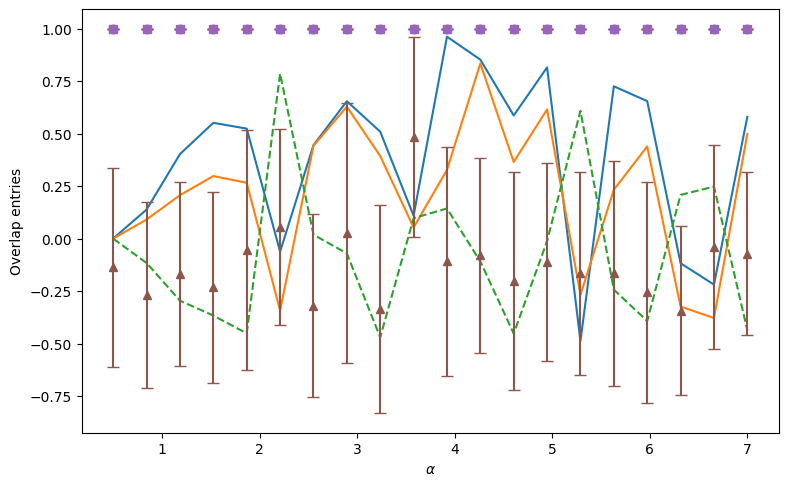

In [11]:
# -*- coding: utf-8 -*-
"""
K = 2 model, centered & normalized readout:
  v_raw = [1, 3]  ->  v_centered = [-1, +1]  ->  v = [-1, +1]/sqrt(2)

Theory: RS K=2 fixed-point solver (matrix-resolvent update).
HMC:    aligned overlaps; plot q11, q22, q12 vs alpha (mean ± 95% CI).
"""

import math
import numpy as np
from numpy.linalg import svd, norm, eigh
from numpy.random import default_rng
from scipy.optimize import linear_sum_assignment
import matplotlib.pyplot as plt
import tensorflow as tf
import hmc2  # your custom module

# ---------------------------
# Repro
# ---------------------------
np.random.seed(123)
tf.random.set_seed(123)

# ---------------------------
# Readout utilities
# ---------------------------
def center_and_l2_normalize(v_raw: np.ndarray) -> np.ndarray:
    v_raw = np.asarray(v_raw, dtype=float)
    v_center = v_raw - v_raw.mean()
    n = np.linalg.norm(v_center)
    if n < 1e-12:
        raise ValueError("Centered readout has near-zero norm; cannot normalize.")
    return v_center / n

# ============================================================
# RS K=2 SOLVER (matrix-resolvent update)
# ============================================================

def project_spectral_ball(M, radius=0.999999):
    """Project 2x2 matrix onto spectral-norm ball: ||M||_2 <= radius."""
    U, s, Vt = svd(M, full_matrices=False)
    s = np.minimum(s, radius)
    return (U * s) @ Vt

def gauge_fix_columns(M):
    """
    Stabilize labels/signs:
    - Flip column signs so diag(M) >= 0
    - Permute columns so diag(M) is descending
    """
    M = M.copy()
    sgn = np.sign(np.diag(M))
    sgn[sgn == 0] = 1.0
    M = M * sgn[np.newaxis, :]
    order = np.argsort(-np.diag(M))
    return M[:, order]

def gaussian_pdf(y, mu, Delta):
    return np.exp(-(y - mu) ** 2 / (2.0 * Delta)) / math.sqrt(2.0 * math.pi * Delta)

def make_y_grid(v, Delta, pad=8.0, Ny=301):
    # |tanh|<=1 => range of v^T tanh(S) is within [-sum|v|, +sum|v|]
    y_max = float(np.sum(np.abs(v)))
    L = y_max + pad * math.sqrt(Delta)
    return np.linspace(-L, L, Ny)

def H_Y_given_U_estimator(M, v, Delta, sig=np.tanh,
                          N_U=300, N_V=150, Ny=241, pad=8.0, rng=None):
    """
    Monte Carlo estimator of H(Y|U) for K=2:
      U ~ N(0,I2), V ~ N(0,I2)
      S = M^T U + L V, with L = sqrt(I - M^T M) (PSD via eig)
      Y = v^T sig(S) + N(0, Delta)
    """
    if rng is None:
        rng = default_rng(123)

    # L = sqrt(I - M^T M) with PSD clip
    MtM = M.T @ M
    A = np.eye(2) - 0.5 * (MtM + MtM.T)
    vals, vecs = eigh(A)
    vals = np.clip(vals, 1e-10, None)
    L = (vecs * np.sqrt(vals)) @ vecs.T

    y_grid = make_y_grid(v, Delta, pad=pad, Ny=Ny)

    U = rng.standard_normal((N_U, 2))
    V = rng.standard_normal((N_V, 2))
    LVt = (L @ V.T)  # (2, N_V)

    H_u_vals = []
    for u in U:
        Mu = M.T @ u              # (2,)
        S = Mu[:, None] + LVt     # (2, N_V)
        g = v @ sig(S)            # (N_V,)

        py = np.mean(gaussian_pdf(y_grid[:, None], g[None, :], Delta), axis=1)
        Z = np.trapz(py, y_grid)
        if Z > 1e-12:
            py = py / Z
        H_u = -np.trapz(py * np.log(np.clip(py, 1e-300, None)), y_grid)
        H_u_vals.append(H_u)

    return float(np.mean(H_u_vals))

def grad_H_numeric(M, v, Delta, sig=np.tanh,
                   N_U=300, N_V=150, Ny=241, pad=8.0, eps=1e-3, rng=None):
    """Central-difference gradient of H(Y|U) wrt M entries (2x2) with CRN."""
    if rng is None:
        rng = default_rng(123)

    G = np.zeros_like(M, dtype=float)
    seeds = rng.integers(0, 2**31 - 1, size=4)

    for i in range(2):
        for j in range(2):
            E = np.zeros((2, 2)); E[i, j] = 1.0
            M_plus  = project_spectral_ball(M + eps * E)
            M_minus = project_spectral_ball(M - eps * E)

            # Common random numbers
            rng_p = default_rng(int(seeds[2*i + j]))
            rng_m = default_rng(int(seeds[2*i + j]))

            Hp = H_Y_given_U_estimator(M_plus,  v, Delta, sig, N_U, N_V, Ny, pad, rng_p)
            Hm = H_Y_given_U_estimator(M_minus, v, Delta, sig, N_U, N_V, Ny, pad, rng_m)
            G[i, j] = (Hp - Hm) / (2.0 * eps)

    return G

def rs_fixed_point_k2_for_alpha(alpha, Delta, v, sig=np.tanh,
                                M_init=None, eta=0.35, max_iter=250, tol=3e-4,
                                N_U=300, N_V=150, Ny=241, pad=8.0, eps_fd=1e-3,
                                rng=None, verbose=False):
    """
    RS fixed point for given α:
      R = -2 α ∇_M H(Y|U; M)
      M_fp = R (I + R)^{-1}  (matrix resolvent)
      M <- (1-η) M + η * M_fp
      Then: spectral projection + gauge fixing.
    """
    if rng is None:
        rng = default_rng(123)

    M = np.zeros((2, 2), dtype=float) if M_init is None else np.array(M_init, dtype=float)
    M += 1e-6 * rng.standard_normal(M.shape)
    M = project_spectral_ball(M)
    M = gauge_fix_columns(M)

    for it in range(1, max_iter + 1):
        G = grad_H_numeric(M, v, Delta, sig, N_U, N_V, Ny, pad, eps_fd, rng)
        R = -2.0 * alpha * G

        I = np.eye(2)
        try:
            M_fp = R @ np.linalg.inv(I + R)
        except np.linalg.LinAlgError:
            M_fp = R @ np.linalg.inv(I + R + 1e-6 * I)

        M_new = (1.0 - eta) * M + eta * M_fp
        M_new = project_spectral_ball(M_new)
        M_new = gauge_fix_columns(M_new)

        if verbose and (it % 10 == 0 or it == 1):
            print(f"[α={alpha:.3g}] iter {it:4d}  |ΔM|={norm(M_new - M):.3e}  ||∇H||={norm(G):.3e}  diag={np.diag(M_new)}")

        if norm(M_new - M) < tol:
            M = M_new
            break
        M = M_new

    info = {'n_iter': it, 'grad_norm': float(norm(G))}
    return M, info

def rs_fixed_point_k2_curve(alpha_values, Delta, v, sig=np.tanh,
                            eta=0.35, max_iter=250, tol=3e-4,
                            N_U=300, N_V=150, Ny=241, pad=8.0, eps_fd=1e-3,
                            rng=None, verbose=False):
    """Solve across α (ascending), warm-starting M. Returns q11, q22, q12 arrays."""
    if rng is None:
        rng = default_rng(123)

    q11_list, q22_list, q12_list = [], [], []
    M_prev = np.zeros((2, 2), dtype=float)

    for a in alpha_values:
        M_sol, _ = rs_fixed_point_k2_for_alpha(
            alpha=a, Delta=Delta, v=v, sig=sig,
            M_init=M_prev, eta=eta, max_iter=max_iter, tol=tol,
            N_U=N_U, N_V=N_V, Ny=Ny, pad=pad, eps_fd=eps_fd,
            rng=rng, verbose=verbose
        )
        q11_list.append(float(M_sol[0, 0]))
        q22_list.append(float(M_sol[1, 1]))
        q12_list.append(float(0.5 * (M_sol[0, 1] + M_sol[1, 0])))
        M_prev = M_sol.copy()

    return np.array(q11_list), np.array(q22_list), np.array(q12_list)

# ============================================================
# HMC-side overlaps for K=2 (empirical)
# ============================================================

def normalized_overlap_matrix(Wstar: np.ndarray, W: np.ndarray):
    """
    Wstar: (d, k), W: (d, k)
    Returns R_{ij} = <w*_i, w_j> / (||w*_i|| ||w_j||), shape (k, k)
    """
    d, k = Wstar.shape
    assert W.shape == (d, k)
    ws_norms = np.maximum(np.linalg.norm(Wstar, axis=0), 1e-16)
    w_norms  = np.maximum(np.linalg.norm(W, axis=0), 1e-16)
    R = (Wstar.T @ W) / np.outer(ws_norms, w_norms)
    return np.clip(R, -1.0, 1.0)

def align_W_to_Wstar(Wstar: np.ndarray, W: np.ndarray):
    """
    Align student columns to teacher columns via Hungarian assignment on -|corr|,
    then flip signs so diagonal overlaps are positive.
    """
    R = normalized_overlap_matrix(Wstar, W)           # (k, k)
    cost = -np.abs(R)
    row_ind, col_ind = linear_sum_assignment(cost)
    W_perm = W[:, col_ind]
    diag_signs = np.sign(np.diag(Wstar.T @ W_perm))
    diag_signs[diag_signs == 0] = 1.0
    W_aligned = W_perm * diag_signs[np.newaxis, :]
    R_aligned = normalized_overlap_matrix(Wstar, W_aligned)
    return W_aligned, col_ind, R_aligned

def empirical_overlaps_for_alpha(alpha, Delta, sig_tf, v_tf,
                                 d=2000, k=2, runs=6, params=None,
                                 burn_in_fraction=0.5, thin=10):
    """
    For given α: run HMC over 'runs' datasets, compute aligned overlap matrix per sample,
    then average q11, q22, q12 across posterior samples and runs.
    """
    if params is None:
        params = dict(step_size=0.01,
                      num_leapfrog_steps=24,
                      num_adaptation_steps=2000,
                      num_post_adapt_steps=200)

    q11_runs, q22_runs, q12_runs = [], [], []

    for _ in range(runs):
        W_star, X, Y, v_hmc = hmc2.data_generate(d, k, alpha, Delta, sig_tf, v_tf)
        Ws_info = hmc2.hmc(params, W_star, X, Y, v_hmc, k, alpha, Delta, sig_tf,
                           show_acceptance_rate=False, show_adaptation_steps=False)

        b = int(len(Ws_info) * burn_in_fraction)
        samples = Ws_info[b::thin] if thin > 1 else Ws_info[b:]

        q11_s, q22_s, q12_s = [], [], []
        W_star_np = W_star.numpy()

        for Wi in samples:
            W_np = Wi.numpy()  # (d,k)
            _, _, R = align_W_to_Wstar(W_star_np, W_np)
            q11_s.append(float(R[0, 0]))
            q22_s.append(float(R[1, 1]))
            q12_s.append(float(0.5 * (R[0, 1] + R[1, 0])))

        if len(q11_s) == 0:
            q11_runs.append(0.0); q22_runs.append(0.0); q12_runs.append(0.0)
        else:
            q11_runs.append(float(np.mean(q11_s)))
            q22_runs.append(float(np.mean(q22_s)))
            q12_runs.append(float(np.mean(q12_s)))

    return (np.array(q11_runs, dtype=float),
            np.array(q22_runs, dtype=float),
            np.array(q12_runs, dtype=float))

def empirical_overlap_stats(alpha_values, Delta, sig_tf, v_tf,
                            d=2000, k=2, runs=6, params=None,
                            burn_in_fraction=0.5, thin=10):
    """For each α, returns mean and SEM across runs for q11, q22, q12."""
    q11_mean, q22_mean, q12_mean = [], [], []
    q11_sem,  q22_sem,  q12_sem  = [], [], []

    for a in alpha_values:
        q11_r, q22_r, q12_r = empirical_overlaps_for_alpha(
            a, Delta, sig_tf, v_tf, d, k, runs, params, burn_in_fraction, thin
        )
        q11_mean.append(q11_r.mean()); q22_mean.append(q22_r.mean()); q12_mean.append(q12_r.mean())
        q11_sem.append(q11_r.std(ddof=1)/np.sqrt(len(q11_r)) if len(q11_r) > 1 else 0.0)
        q22_sem.append(q22_r.std(ddof=1)/np.sqrt(len(q22_r)) if len(q22_r) > 1 else 0.0)
        q12_sem.append(q12_r.std(ddof=1)/np.sqrt(len(q12_r)) if len(q12_r) > 1 else 0.0)

    return (np.array(q11_mean), np.array(q22_mean), np.array(q12_mean),
            np.array(q11_sem),  np.array(q22_sem),  np.array(q12_sem))

# ---------------------------
# Optional: design scaling check
# ---------------------------
def check_design_scaling(X, W_star):
    d = W_star.shape[0]
    for j in range(W_star.shape[1]):
        s = tf.linalg.matvec(X, W_star[:, j]).numpy()
        var_emp = float(np.var(s))
        q_star_jj = float(tf.reduce_sum(W_star[:, j]**2).numpy() / d)
        ratio = var_emp / q_star_jj if q_star_jj > 0 else float('nan')
        print(f"[scaling] unit {j}: Var(X w*_j)≈{var_emp:.4f}; q*_jj≈{q_star_jj:.4f}; ratio={ratio:.2f} (want ~1)")

# ---------------------------
# Main
# ---------------------------
if __name__ == "__main__":
    # Activation
    sig_np = np.tanh
    sig_tf = tf.nn.tanh

    # Noise
    Delta = 0.1

    # k and readout: center & normalize [1, 3]
    k = 2
    v_raw = np.array([1.0, 3.0], dtype=float)
    v = center_and_l2_normalize(v_raw)            # [-1, +1]/sqrt(2)
    print(f"[readout] v_raw={v_raw.tolist()}  ->  centered+L2norm v={v.tolist()}  (||v||={np.linalg.norm(v):.3f})")

    v_np = v.copy()
    v_tf = tf.constant(v, dtype=tf.float32)

    # α grid
    alpha_values = np.linspace(0.5, 7.0, 20)

    # THEORY (RS K=2 solver)
    q11_th, q22_th, q12_th = rs_fixed_point_k2_curve(
        alpha_values, Delta, v_np, sig=sig_np,
        eta=0.35, max_iter=250, tol=3e-4,
        N_U=300, N_V=150, Ny=241, pad=8.0, eps_fd=1e-3,
        rng=default_rng(123), verbose=False
    )

    # HMC params
    hmc_params = dict(
        step_size=0.01,
        num_leapfrog_steps=24,
        num_adaptation_steps=2000,
        num_post_adapt_steps=200,
    )

    # EMPIRICAL overlaps (means ± SEM across runs)
    d = 1500
    runs = 8
    (q11_m, q22_m, q12_m,
     q11_sem, q22_sem, q12_sem) = empirical_overlap_stats(
        alpha_values, Delta, sig_tf, v_tf,
        d=d, k=k, runs=runs, params=hmc_params,
        burn_in_fraction=0.5, thin=10
    )

    # ---------------------------
    # Plot q_11, q_22, q_12 vs α
    # ---------------------------
    plt.figure(figsize=(9, 5.5))

    # THEORY: lines from RS solver
    plt.plot(alpha_values, q11_th, '-',  label='q11 (theory RS)')
    plt.plot(alpha_values, q22_th, '-',  label='q22 (theory RS)')
    plt.plot(alpha_values, q12_th, '--', label='q12 (theory RS)')

    # HMC: markers + error bars (95% CI), no connecting line
    ci = 1.96
    plt.errorbar(alpha_values, q11_m, yerr=ci * q11_sem, fmt='o', linestyle='None', capsize=4, label='q11 (HMC)')
    plt.errorbar(alpha_values, q22_m, yerr=ci * q22_sem, fmt='s', linestyle='None', capsize=4, label='q22 (HMC)')
    plt.errorbar(alpha_values, q12_m, yerr=ci * q12_sem, fmt='^', linestyle='None', capsize=4, label='q12 (HMC)')

    plt.xlabel(r'$\alpha$')
    plt.ylabel('Overlap entries')
    plt.title(r'K=2 RS vs HMC, centered+normalized $v=[1,3]\rightarrow[-1,1]/\sqrt{2}$, '
              r'$\Delta={}$, d={}, runs={}'.format(Delta, d, runs))

    # Legend outside, mid-right
    leg = plt.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), frameon=True, borderaxespad=0.0)
    plt.gcf().subplots_adjust(right=0.78)

    plt.tight_layout()
    plt.savefig("k2_overlaps_vs_alpha_centered_norm_v13.png", dpi=300, bbox_inches='tight')
    plt.show()
